# Check # cell / detection power correlation

## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import statistics as stat
import json
import csv
import re
import copy
from sklearn.preprocessing import OneHotEncoder

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
import snapatac2 as snap

In [4]:
from cuml import UMAP

In [5]:
scp.__version__

'1.0.0a'

In [6]:
# Set seed
import random
import numpy as np
random.seed(42)
np.random.seed(42)

### 0.1 Setup

In [7]:
# Specify the reference genome. This must match that of your ATAC fragments file
genome = scp.genome.mm10

genome

Define objective

In [8]:
chromVAR_or_seq2PRINT = 'chromvar'

In [9]:
# Set a seed
seed = 42
np.random.seed(seed)

## 1. Paths

### 1.1 Data directories

In [10]:
master_data_dir = '/bap/bap/collab_asthma_multiome/'

TODO: paths are messy you should clean this up soon

In [11]:
barcode_subtype_mapping_csv_file_path = os.path.join(master_data_dir, 'outputs', 'ATAC', '2_Analysis_Outputs', '1a_ChromVAR_Inputs', 'sample_barcode_predicted_cluster_df.csv')

# outputs
printer_h5ad_output_dir = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', '1b_ChromVAR_scPrinter_object')
scprinter_obj_path = os.path.join(printer_h5ad_output_dir, 'Asthma_Multiome_Collab_scPrinter.h5ad')
# peak_path = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', '1c_chromvar_scPrinter_MACS_peaks', 'chromVAR_preset_Asthma_Multiome_scPrinter_cleaned_merged_narrowPeak.bed')

output_dir = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', f'1d_{chromVAR_or_seq2PRINT}_Outputs')
chromvar_h5ad_path = f'{output_dir}/chromvar_FigR.h5ad'

# if the output directory does not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
chromvar_h5ad_path

'/bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/chromvar_FigR.h5ad'

## 2. Load chromVAR results

### 2.1 Load ChromVAR results

In [13]:
chromvar = anndata.read_h5ad(chromvar_h5ad_path)

In [14]:
chromvar

AnnData object with n_obs × n_vars = 7418 × 890

In [15]:
# Read csv yes header

barcode_subtype_mapping_df = pd.read_csv(barcode_subtype_mapping_csv_file_path, header=0)

# Set the index of barcode_subtype_mapping_df to 'Barcode' for easy matching
barcode_subtype_mapping_df_reindexed = barcode_subtype_mapping_df.set_index('Barcode', inplace=False)

# Reindex barcode_subtype_mapping_df to match the order of chromvar.obs_names
barcode_subtype_mapping_df_reindexed = barcode_subtype_mapping_df_reindexed.reindex(chromvar.obs_names)

# Add the 'Cluster' column to chromvar.obs
chromvar.obs['Cluster'] = barcode_subtype_mapping_df_reindexed['Cluster']

# Function to extract the sample name from the barcode
def extract_sample_name(barcode):
    parts = barcode.split('_')
    if len(parts) > 1:
        return '_'.join(parts[:-1])  # Join all parts except the last one
    else:
        return barcode.split('-')[0]

# Apply the function to extract sample names using a list comprehension
chromvar.obs['SampleName'] = [extract_sample_name(barcode) for barcode in chromvar.obs_names]

# Verify the added columns
print(chromvar.obs.head())

                      Cluster SampleName
NT_AAACAGCCAGTTTCTC-1     NG4         NT
NT_AAACGGATCAATAGCC-1     JG6         NT
NT_AAACGGATCCTAATGA-1     JG1         NT
NT_AAACGTACAAAGCCTC-1     NG5         NT
NT_AAACGTACATGTGGGA-1     JG1         NT


### 2.2 Load motif scoring results

In [16]:
summary_df_individual_controls = pd.read_csv(os.path.join(output_dir, 'Prescott2020_subtype_comparisons_individual_controls', 'summary_comparisons.csv'), header=0)

In [17]:
summary_df_lumped_controls = pd.read_csv(os.path.join(output_dir, 'Prescott2020_subtype_comparisons_combine_controls', 'summary_comparisons.csv'), header=0)

In [18]:
print(summary_df_individual_controls.shape)
print(summary_df_lumped_controls.shape)

(214, 4)
(286, 4)


In [19]:
summary_df_individual_controls.head()

,Comparison,# significantly up,# significantly down,Total
0,JG3-OVA_vs_JG3-PBS_C,329,134,463
1,NG6-OVA_C_vs_NG6-PBS,174,126,300
2,JG1-OVA_C_vs_JG1-PBS,100,172,272
3,NG13-OVA_vs_NG13-PBS_C,74,182,256
4,JG4-OVA_C_vs_JG4-PBS_C,122,123,245


In [20]:
summary_df_lumped_controls.head()

,Comparison,# significantly up,# significantly down,Total
0,JG3-OVA_vs_JG3-PBS_C,329,134,463
1,NG6-OVA_C_vs_NG6-PBS,174,126,300
2,JG1-OVA_C_vs_JG1-PBS,100,172,272
3,NG13-OVA_vs_NG13-PBS_C,74,182,256
4,JG4-OVA_C_vs_JG4-PBS_C,122,123,245


## 3. Is there a correlation between # of pass-QC cells and detection power?

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_cell_count_vs_significant_summary(summary_df, obs_df, lump_control_names, 
                                           output_dir=None, 
                                           plot_filename="correlation_plot_ratio.png", 
                                           csv_filename="combined_summary.csv"):
    """
    Given a summary dataframe that contains both individual and lumped comparisons 
    (with the 'Comparison' column, where lumped comparisons are labeled with '_vs_lumped'),
    this function:
      1. Adds columns for the number of case cells and for the number of control cells
         (using the lumped control names provided) for each comparison.
      2. Computes a new column "ratio" = (n_case)/(n_control).
      3. Computes the Pearson correlation between this ratio and the total number of significant motifs.
      4. Generates a scatter plot (dpi=300) with x-axis = ratio and y-axis = Total (# significant motifs).
         Lumped comparisons are highlighted in red and individual comparisons in gray.
      5. Additionally, generates two more scatter plots: one of n_case vs Total and one of n_control vs Total,
         each with Pearson correlation annotated.
      6. Writes the updated summary table as a CSV file to output_dir.
    
    Parameters
    ----------
    summary_df : pd.DataFrame
        Summary table containing at least the columns: 
          'Comparison', '# significantly up', '# significantly down', 'Total'
        It should include both individual and lumped comparisons.
    obs_df : pd.DataFrame
        The single-cell observations dataframe, which must contain at least the columns 
        'Cluster' and 'SampleName'.
    lump_control_names : list of str
        List of control sample names used to compute the control cell count (e.g. ["NT", "PBS", "PBS_C"]).
    output_dir : str, optional
        Directory in which to save the CSV and the plots.
    plot_filename : str, optional
        Filename for the ratio vs Total plot.
    csv_filename : str, optional
        Filename for the combined summary CSV.
    
    Returns
    -------
    combined_df : pd.DataFrame
        The updated summary dataframe with added columns for n_case, n_control, and ratio.
    corr_result : tuple
        Pearson correlation coefficient and p-value (for the ratio vs Total plot).
    """
    # Work on a copy.
    summary_df = summary_df.copy()
    
    # Add a "Comparison_Type" column if not already present.
    if "Comparison_Type" not in summary_df.columns:
        summary_df["Comparison_Type"] = summary_df["Comparison"].apply(
            lambda x: "lumped" if x.endswith("_vs_lumped") else "individual"
        )
    
    # Count comparisons by type.
    num_lumped = (summary_df["Comparison_Type"] == "lumped").sum()
    num_individual = (summary_df["Comparison_Type"] == "individual").sum()
    print("Number of individual comparisons:", num_individual)
    print("Number of lumped comparisons:", num_lumped)
    
    # Helper: given a comparison label, extract the cluster and case.
    def get_case_cell_count(comp_label, obs):
        try:
            case_str = comp_label.split("_vs_")[0]  # e.g. "NG2-OVA" or "JG1-OVA_C"
            cluster, sample = case_str.split('-', 1)
        except Exception:
            return np.nan
        count = obs[(obs["Cluster"] == cluster) & (obs["SampleName"] == sample)].shape[0]
        return count

    # Helper: given a comparison label and lump control names, compute total control cell count.
    def get_control_cell_count(comp_label, obs, control_names):
        try:
            # Extract cluster from the case part.
            case_str = comp_label.split("_vs_")[0]
            cluster, _ = case_str.split('-', 1)
        except Exception:
            return np.nan
        count = 0
        for ctrl in control_names:
            count += obs[(obs["Cluster"] == cluster) & (obs["SampleName"] == ctrl)].shape[0]
        return count
    
    # Add columns for number of case cells and control cells.
    summary_df["n_case"] = summary_df["Comparison"].apply(lambda x: get_case_cell_count(x, obs_df))
    summary_df["n_control"] = summary_df["Comparison"].apply(lambda x: get_control_cell_count(x, obs_df, lump_control_names))
    
    # Compute ratio = n_case / n_control.
    summary_df["ratio"] = summary_df.apply(lambda row: row["n_case"] / row["n_control"] 
                                             if row["n_control"] > 0 else np.nan, axis=1)
    
    # Compute Pearson correlation between ratio and Total.
    valid = summary_df.dropna(subset=["ratio", "Total"])
    r, pval = pearsonr(valid["ratio"], valid["Total"])
    
    # --- Plot 1: Ratio vs Total ---
    plt.figure(dpi=300, figsize=(6, 5))
    ind_mask = summary_df["Comparison_Type"] == "individual"
    lump_mask = summary_df["Comparison_Type"] == "lumped"
    plt.scatter(summary_df.loc[ind_mask, "ratio"], summary_df.loc[ind_mask, "Total"],
                color="gray", edgecolor="black", marker="o", s=80, label="Individual")
    plt.scatter(summary_df.loc[lump_mask, "ratio"], summary_df.loc[lump_mask, "Total"],
                color="red", edgecolor="black", marker="o", s=80, label="Lumped")
    plt.xlabel("Case / Control cell ratio")
    plt.ylabel("Total # of significant motifs")
    plt.title("Ratio vs. Significant Motifs")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.text(0.05, 0.95, f"Pearson r = {r:.2f}\np = {pval:.2e}", transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.6))
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        plot_path = os.path.join(output_dir, plot_filename)
        plt.savefig(plot_path, bbox_inches="tight", dpi=300)
    plt.show()
    
    # --- Plot 2: n_case vs Total ---
    valid_ncase = summary_df.dropna(subset=["n_case", "Total"])
    r_nc, pval_nc = pearsonr(valid_ncase["n_case"], valid_ncase["Total"])
    plt.figure(dpi=300, figsize=(6, 5))
    plt.scatter(summary_df.loc[ind_mask, "n_case"], summary_df.loc[ind_mask, "Total"],
                color="gray", edgecolor="black", marker="o", s=80, label="Individual")
    plt.scatter(summary_df.loc[lump_mask, "n_case"], summary_df.loc[lump_mask, "Total"],
                color="red", edgecolor="black", marker="o", s=80, label="Lumped")
    plt.xlabel("Number of case cells")
    plt.ylabel("Total # of significant motifs")
    plt.title("Case Cell Count vs. Significant Motifs")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.text(0.05, 0.95, f"Pearson r = {r_nc:.2f}\np = {pval_nc:.2e}", transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.6))
    if output_dir is not None:
        plot_path2 = os.path.join(output_dir, "n_case_vs_total.png")
        plt.savefig(plot_path2, bbox_inches="tight", dpi=300)
    plt.show()
    
    # --- Plot 3: n_control vs Total ---
    valid_ncontrol = summary_df.dropna(subset=["n_control", "Total"])
    r_nc2, pval_nc2 = pearsonr(valid_ncontrol["n_control"], valid_ncontrol["Total"])
    plt.figure(dpi=300, figsize=(6, 5))
    plt.scatter(summary_df.loc[ind_mask, "n_control"], summary_df.loc[ind_mask, "Total"],
                color="gray", edgecolor="black", marker="o", s=80, label="Individual")
    plt.scatter(summary_df.loc[lump_mask, "n_control"], summary_df.loc[lump_mask, "Total"],
                color="red", edgecolor="black", marker="o", s=80, label="Lumped")
    plt.xlabel("Number of control cells")
    plt.ylabel("Total # of significant motifs")
    plt.title("Control Cell Count vs. Significant Motifs")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.text(0.05, 0.95, f"Pearson r = {r_nc2:.2f}\np = {pval_nc2:.2e}", transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.6))
    if output_dir is not None:
        plot_path3 = os.path.join(output_dir, "n_control_vs_total.png")
        plt.savefig(plot_path3, bbox_inches="tight", dpi=300)
    plt.show()
    
    # Save the combined summary CSV.
    if output_dir is not None:
        csv_path = os.path.join(output_dir, csv_filename)
        summary_df.to_csv(csv_path, index=False)
    
    return summary_df, (r, pval)



In [22]:
# --- Assertion snippet to check that individual comparisons are a subset ---

# Suppose summary_df_individual_controls is the summary from individual controls only,
# and summary_df_lumped_controls is from run_comparisons with lump_controls specified.
# Then you can assert:
assert set(summary_df_individual_controls["Comparison"]).issubset(set(summary_df_lumped_controls["Comparison"]))
# (Uncomment the line below if your dataframes are available)
assert set(summary_df_individual_controls["Comparison"]).issubset(set(summary_df_lumped_controls["Comparison"]))


Number of individual comparisons: 214
Number of lumped comparisons: 72


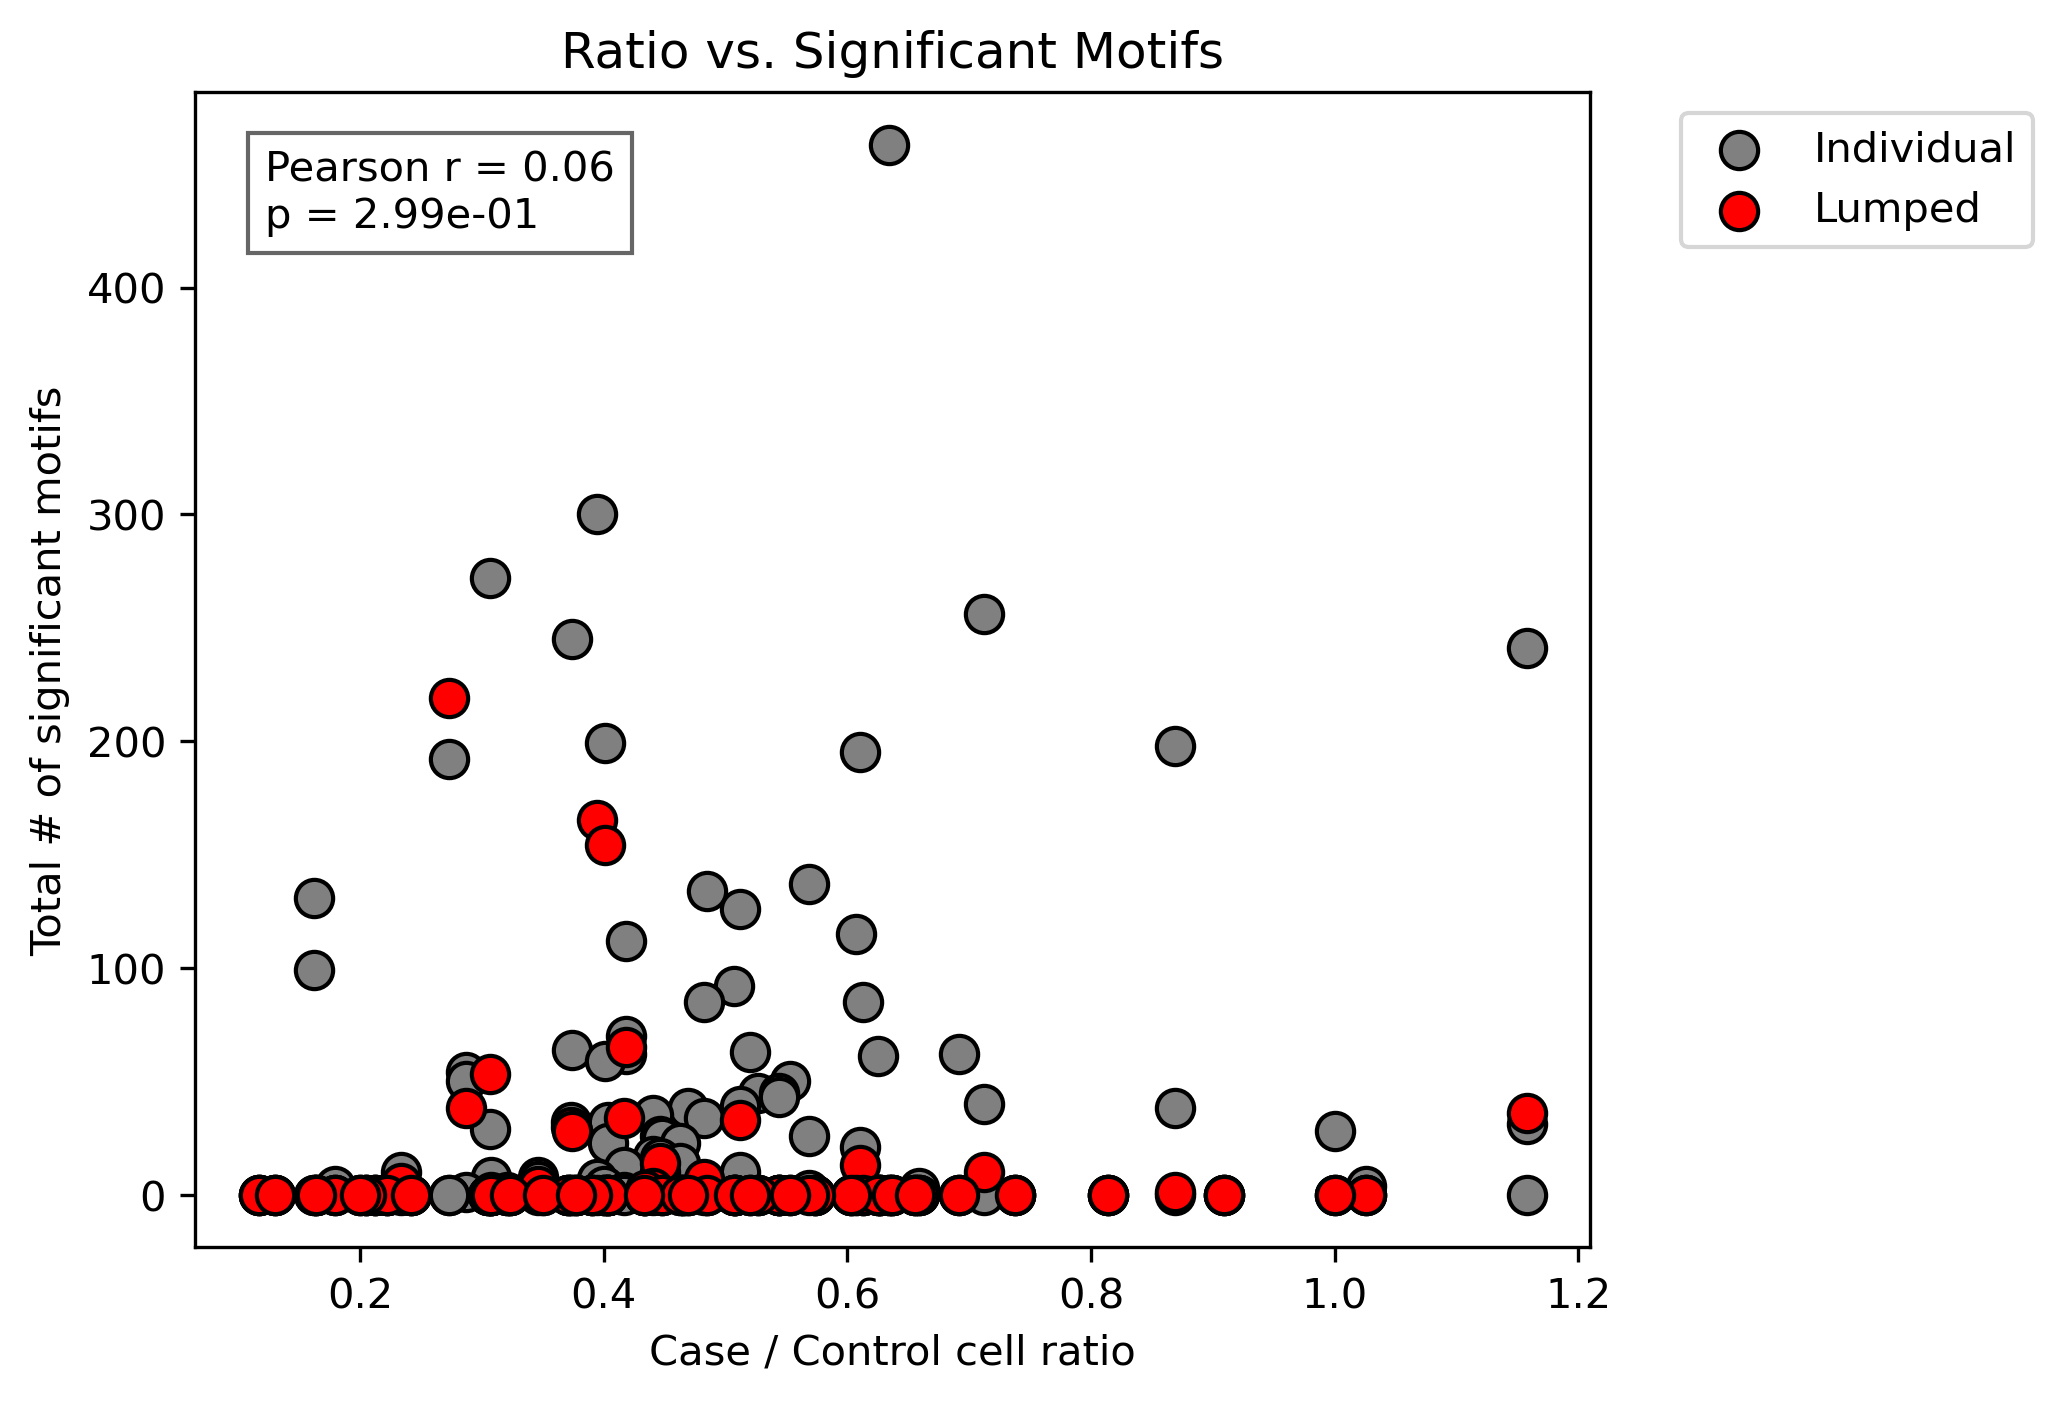

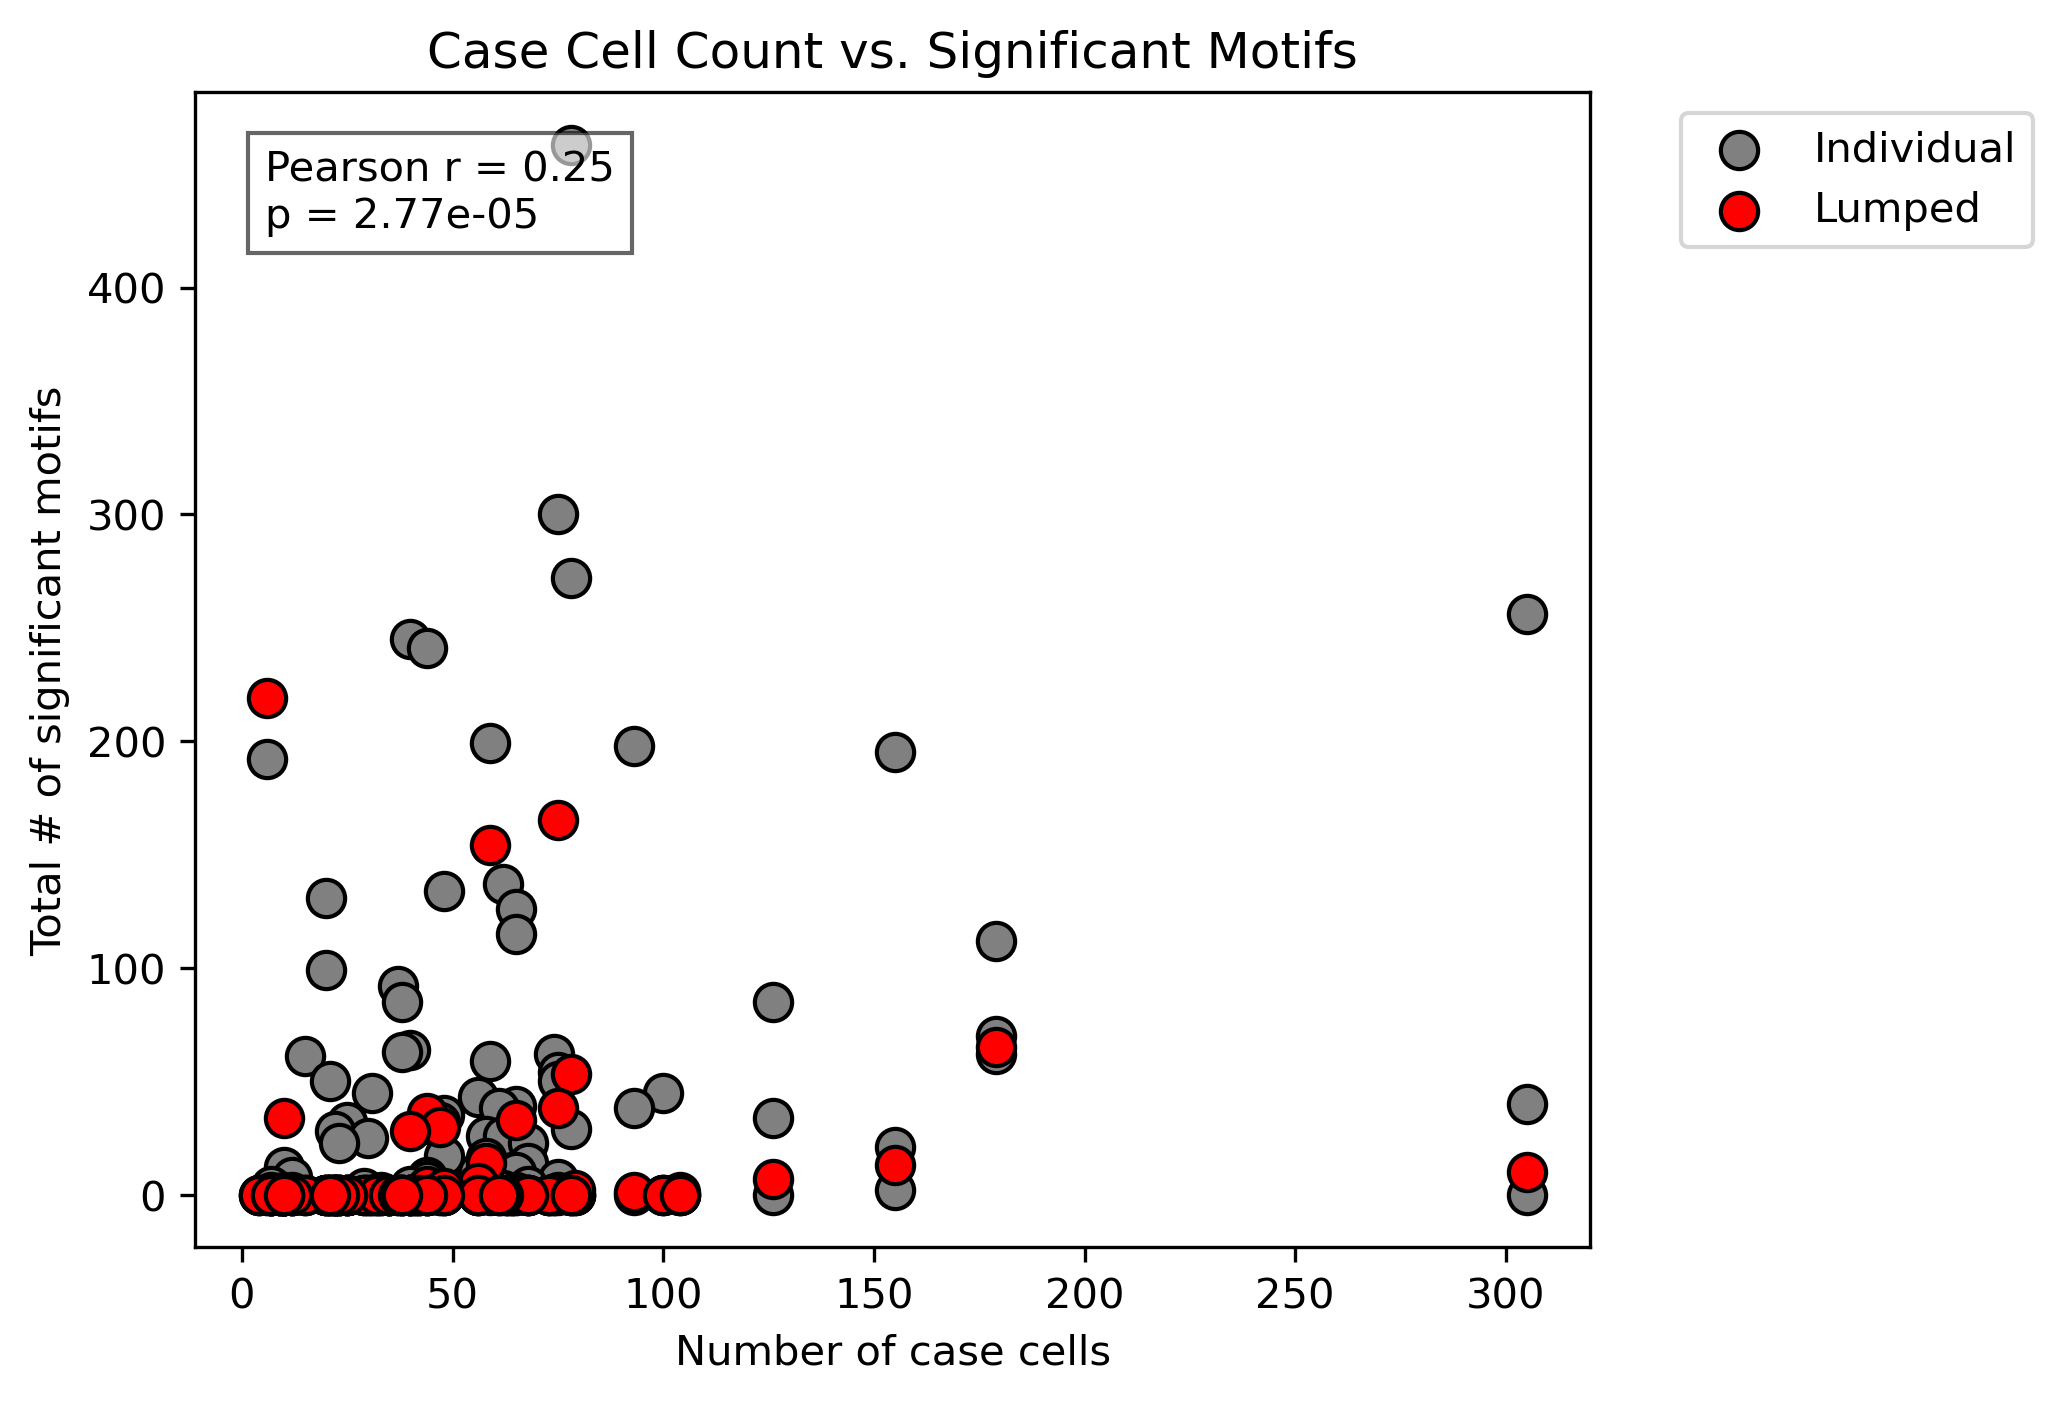

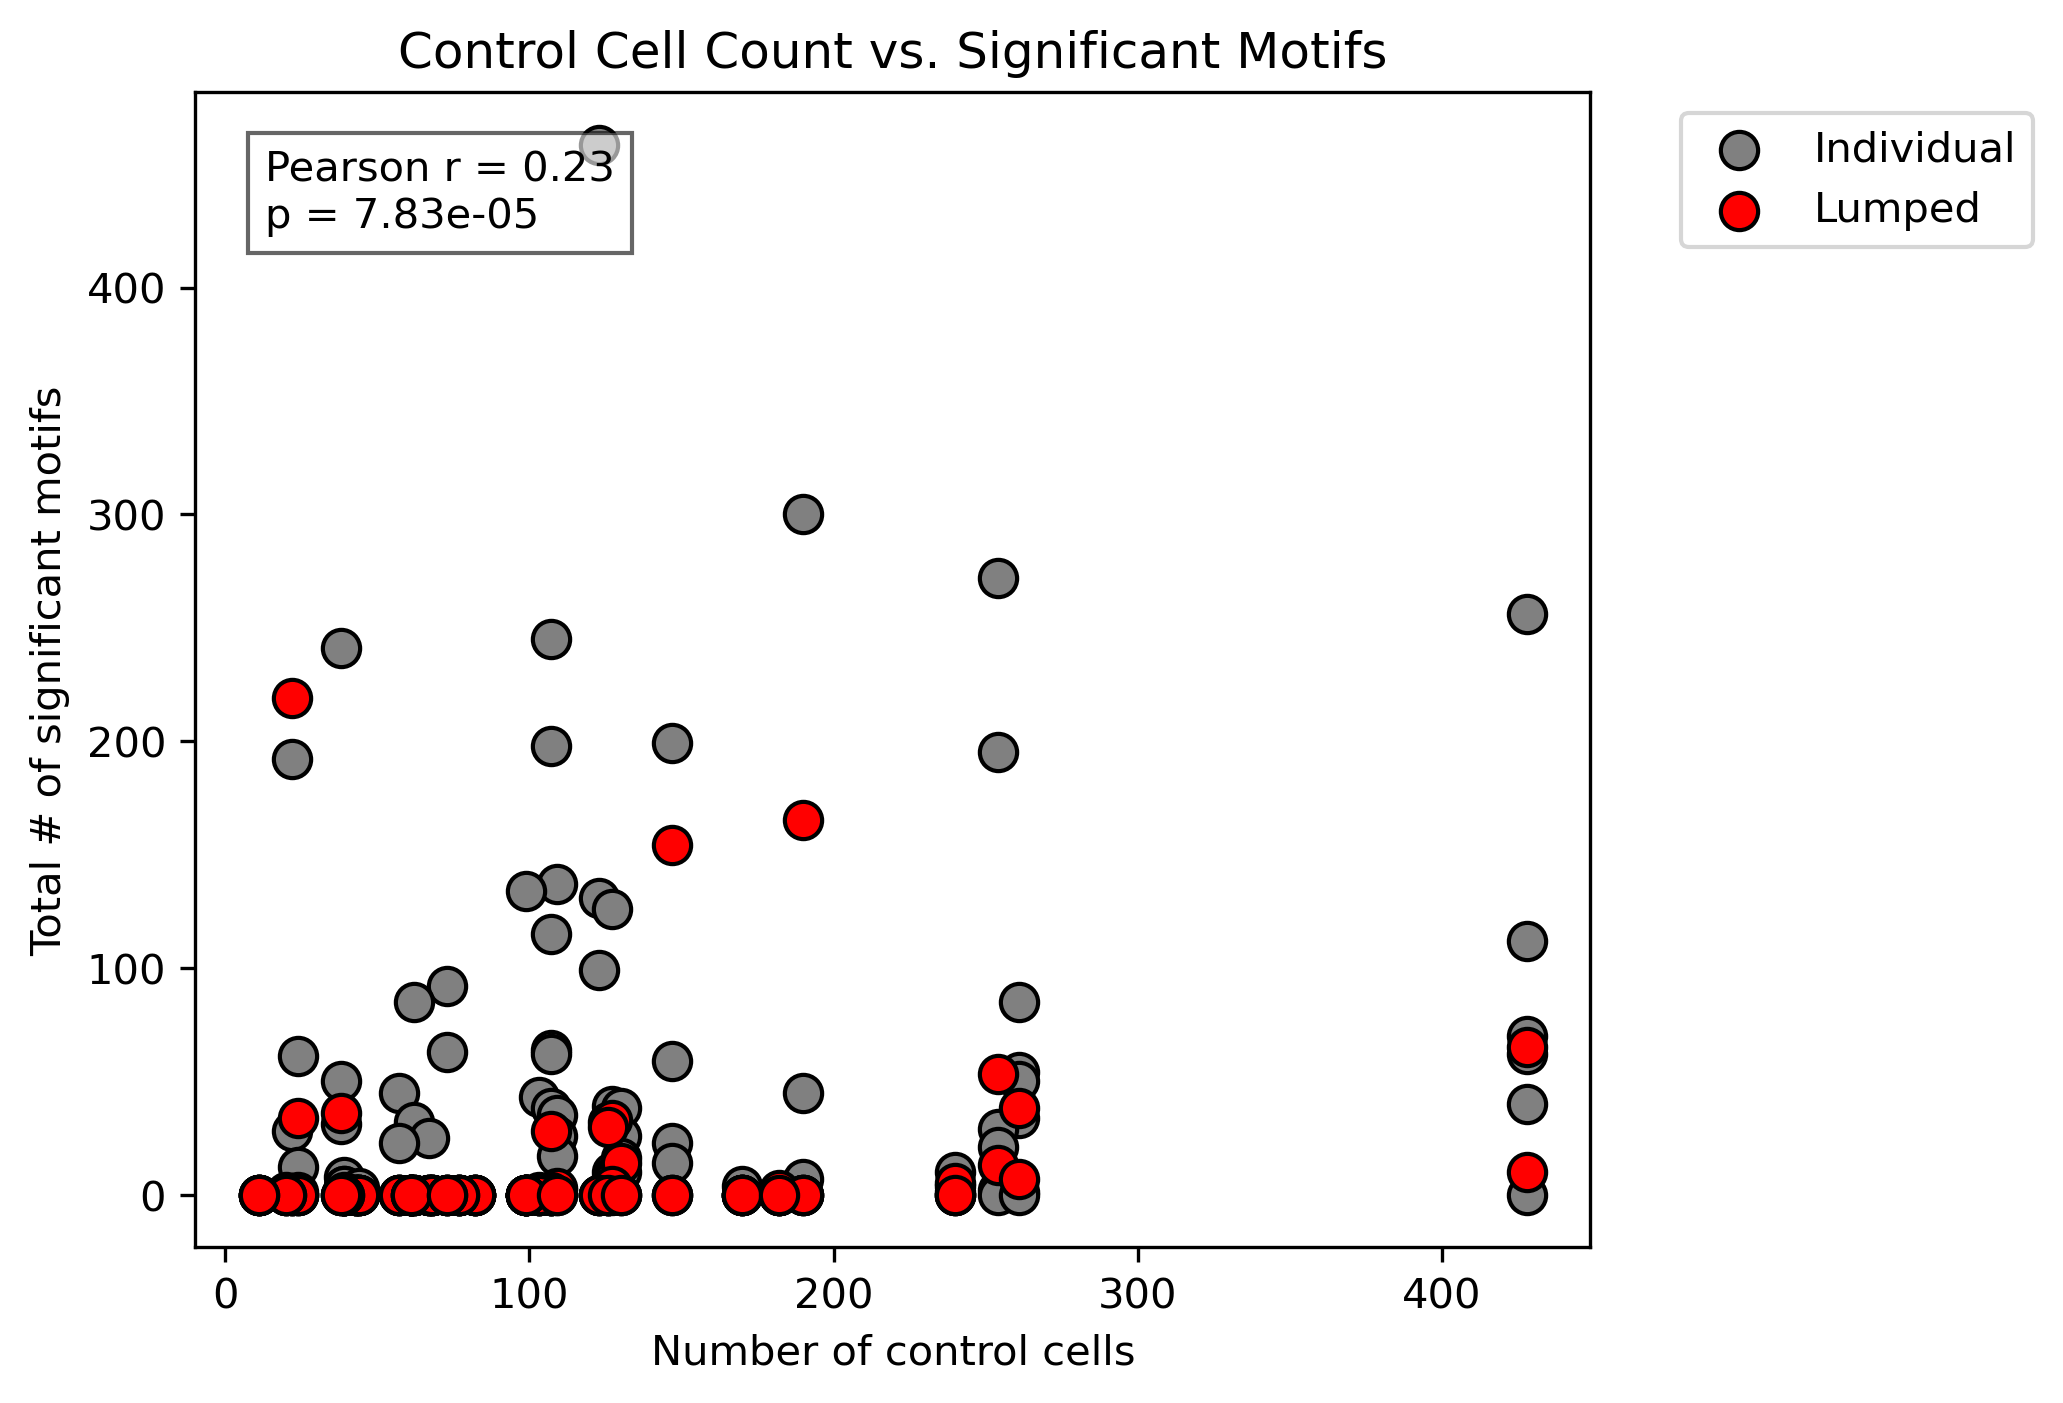

Pearson correlation: (0.06160268729556495, 0.29916771494293487)


In [23]:
combined_summary, corr = plot_cell_count_vs_significant_summary(summary_df_lumped_controls, 
                                                                 chromvar.obs, 
                                                                 lump_control_names=["NT", "PBS", "PBS_C"],
                                                                 output_dir="output/summary_analysis")

print("Pearson correlation:", corr)

In [24]:
combined_summary

,Comparison,# significantly up,# significantly down,Total,Comparison_Type,n_case,n_control,ratio
0,JG3-OVA_vs_JG3-PBS_C,329,134,463,individual,78,123,0.634146
1,NG6-OVA_C_vs_NG6-PBS,174,126,300,individual,75,190,0.394737
2,JG1-OVA_C_vs_JG1-PBS,100,172,272,individual,78,254,0.307087
3,NG13-OVA_vs_NG13-PBS_C,74,182,256,individual,305,428,0.712617
4,JG4-OVA_C_vs_JG4-PBS_C,122,123,245,individual,40,107,0.373832
...,...,...,...,...,...,...,...,...
281,NG2-OVA_vs_NG2-PBS,0,0,0,individual,61,130,0.469231
282,NG2-OVA_vs_lumped,0,0,0,lumped,61,130,0.469231
283,NG21-OVA_vs_NG21-NT,0,0,0,individual,10,11,0.909091
284,NG21-OVA_vs_NG21-PBS,0,0,0,individual,10,11,0.909091


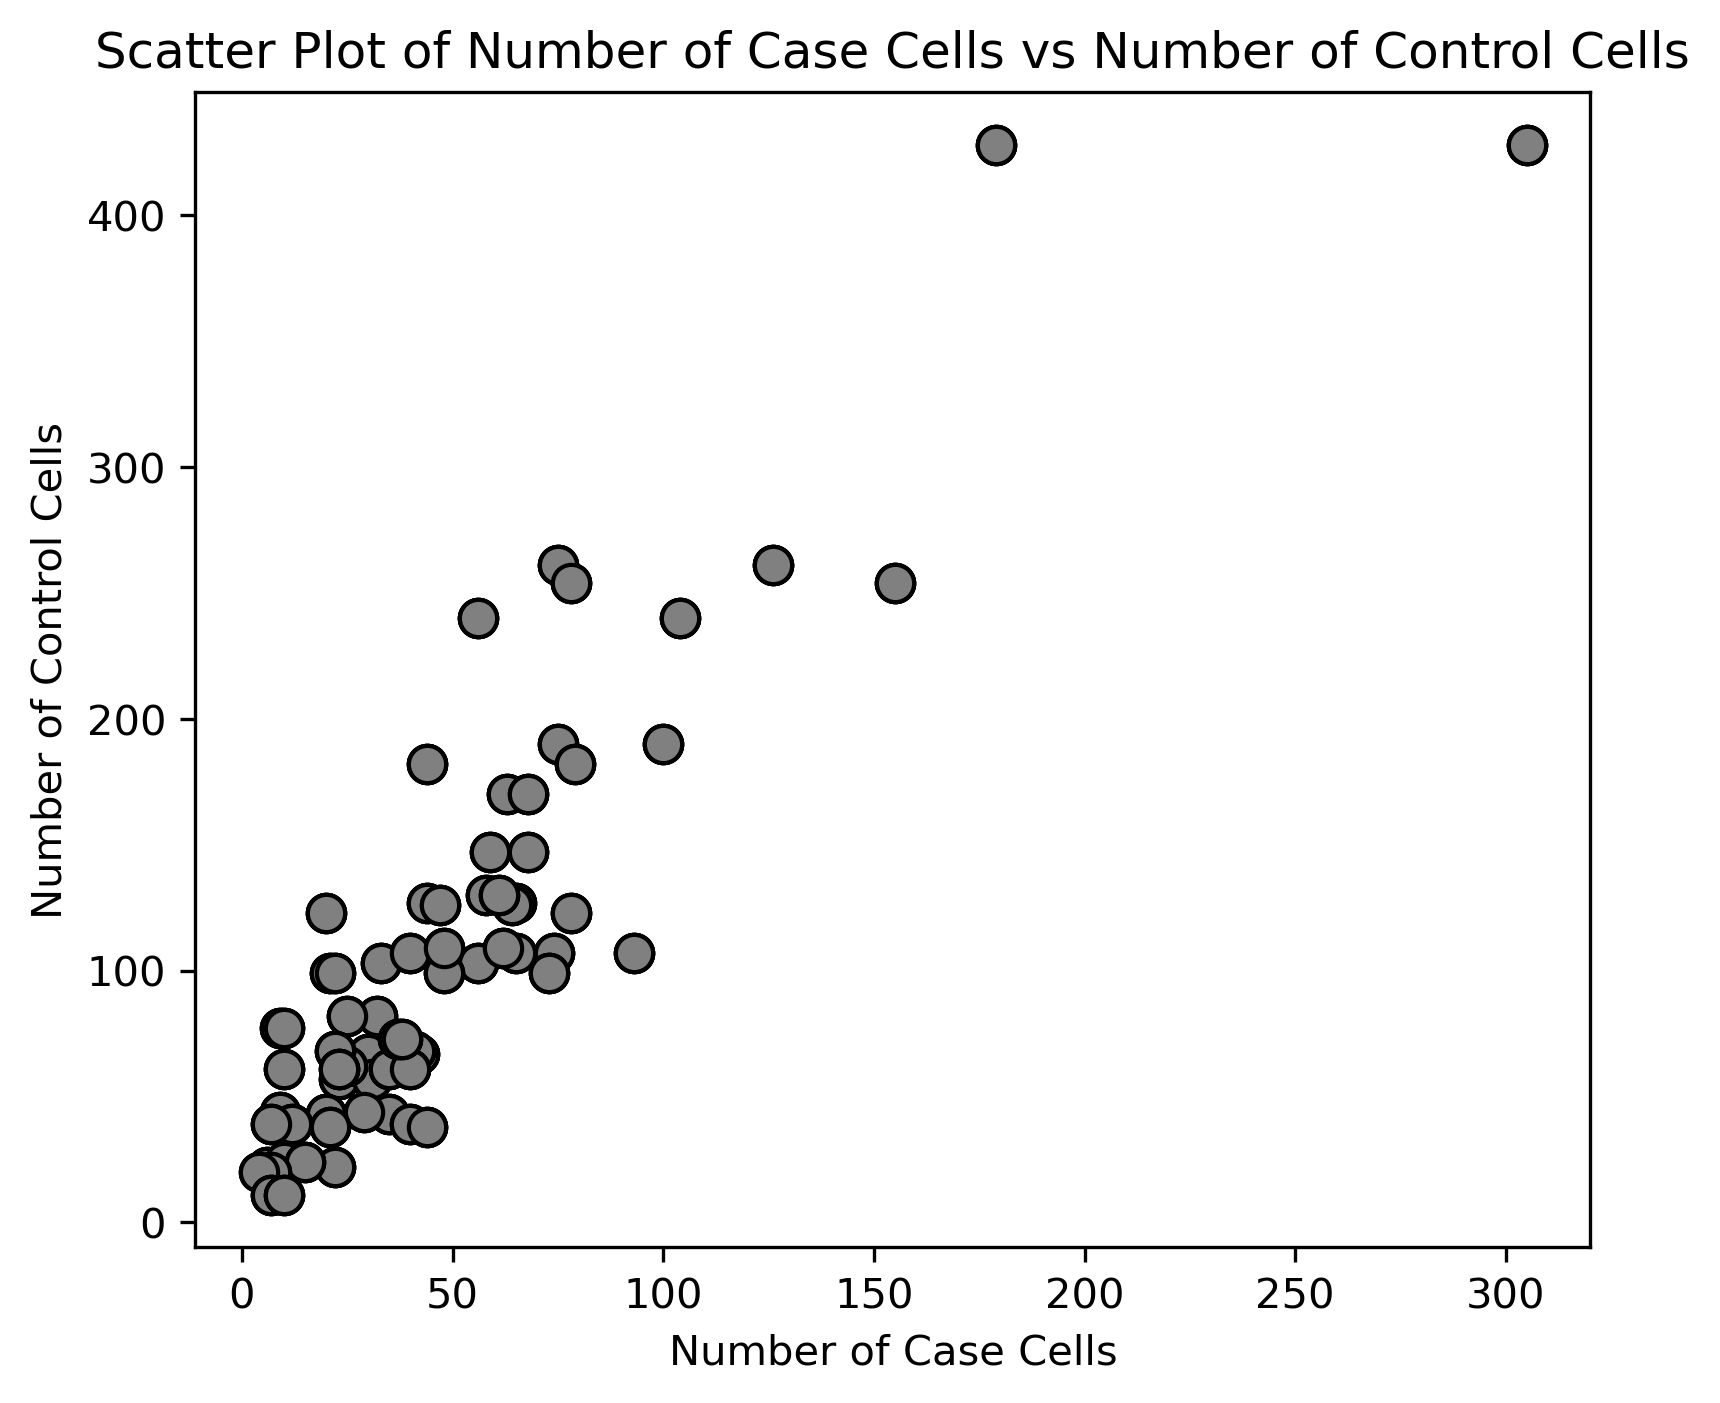

In [25]:
# Create the scatter plot for n_case vs n_control
plt.figure(dpi=300, figsize=(6, 5))
plt.scatter(combined_summary["n_case"], combined_summary["n_control"], color="gray", edgecolor="black", marker="o", s=80)
plt.xlabel("Number of Case Cells")
plt.ylabel("Number of Control Cells")
plt.title("Scatter Plot of Number of Case Cells vs Number of Control Cells")
plt.grid(False)

plt.show()

In [26]:
text = "JG1-OVA_C"
parts = text.split('-', 1)
print("Original text:", text)
print("Result of split('-', 1):", parts)

Original text: JG1-OVA_C
Result of split('-', 1): ['JG1', 'OVA_C']


# END